# autocorrelation parametric estimation with maximum likehood

This notebook adapts Fleming et al. 2014 to the estimation of drifter's velocity autocorrelations.
Unlike Fleming et al. 2014, we'll not be concerned with position statistics but velocity statistics.


### references:
- [Fleming et al. 2014](https://www.google.com/search?q=10.1111%2F2041-210X.12176): Non-Markovian maximum likelihood estimation of autocorrelated movement processes
- [Gurarie et al. 2017](https://movementecologyjournal.biomedcentral.com/articles/10.1186/s40462-017-0103-3): Correlated velocity models as a fundamental unit of animal movement: synthesis and applications
- [Pawitan 2001](https://books.google.fr/books?id=M-3pSCVxV5oC&printsec=frontcover&redir_esc=y#v=onepage&q&f=false): In All Likelihood: Statistical Modelling and Inference Using Likehood

---
## univariate case

We consider a real time series $u(t)$ and aim at estimating it's mean $\mu(t) = \langle u(t) \rangle$, it's variance along with parameters describing its autocorrelation $\sigma(t, t')$ (e.g. time scale of decay), where:

\begin{align}
\sigma(t, t') = \big \langle (u(t) - \mu) (u(t') - \mu) \big \rangle
\end{align}

We'll assume that the time series follows a Gaussian distribution.
**This Gaussian assumption may/should be verified in practice**.
We'll also assume now that data is discrete such that the marginal probability distribution of the observed time-series data is given by:

\begin{align}
P[\mathbf{u}] = 
\frac{\exp \Big ( -\frac{1}{2} [ \mathbf{u} - \mathbf{m} ]^T \boldsymbol{\Sigma}^{-1} [ \mathbf{u} - \mathbf{m} ] \Big )  }
{\sqrt{(2\pi)^N |\mathbf{\boldsymbol{\Sigma}}|}},
\end{align}

where $N$ is the number of data points, $\mathbf{u}$ is the velocity time series, $\mathbf{m}$ is the sampled mean, and $\boldsymbol{\Sigma}$ is the sampled autocorrelation:

\begin{align}
\mathbf{U}_i &=u(t_i), \\
\mathbf{M}_i &=\mu(t_i), \\
\boldsymbol{\Sigma}_{i,j} &= \sigma(t_i,t_j).
\end{align}

where mean and autocorrelation may not be stationary (in general, they will be below).
The log-likelhood function is then:

\begin{align}
L = -\frac{1}{2} \log | \boldsymbol{\Sigma} | 
- \frac{1}{2} [ \mathbf{u} - \mathbf{m} ]^T \boldsymbol{\Sigma}^{-1} [ \mathbf{u} - \mathbf{m} ].
\end{align}

Note that we dropped the $2\pi$ factor here but the combinations of different time series with unequal length may require to consider its contribution.
We assume from now on that statistics are stationary: $\mu(t)=\mu$, $\sigma(t,t')=\sigma(t'-t)$.
We'll also assume the autocorrelation may be written as $\sigma(t'-t)=\sigma_0 c(t'-t)$, where $\sigma_0$ is the variance of the signal.
The likelihood is then written as:

\begin{align}
L = -\frac{1}{2} \log | \boldsymbol{C} | 
-\frac{N}{2} \log \sigma_0
- \frac{1}{2\sigma_0} [ \mathbf{u} - \mu\mathbb{1} ]^T \boldsymbol{C}^{-1} [ \mathbf{u} - \mu\mathbb{1} ]
\end{align}



The goal is now to find the maximum likelihood over $\mu$, $\sigma_0$ and the parameters describing $c$.
The process of finding this maximum may be decomposed into maximizations over $\mu$ and $\sigma_0$ and then autocorrelation parameters.

### profiling the mean

\begin{align}
\frac{\partial L}{\partial \mu} &= \frac{1}{\sigma_0} \mathbb{1}^T \boldsymbol{C}^{-1} [ \mathbf{u} - \mu\mathbb{1} ],
\end{align}

which, when equalled to zero, leads to the following value for the mean:

\begin{align}
\hat{\mu} &= \frac{\mathbb{1}^T \boldsymbol{C}^{-1} \mathbf{u}}{\mathbb{1}^T \boldsymbol{C}^{-1} \mathbb{1}}, \\
&= \frac{\sum_i w_i u_j}{\sum_{i} w_i}, \\
w_i &= \sum_{j} c_{ij}^{-1}.
\end{align}

Observed Fisher information (Pawitan p32) is:

\begin{align}
I &= -\frac{\partial^2 L}{\partial \mu^2}, \\
&= \frac{1}{\sigma_0} \mathbb{1}^T \boldsymbol{C}^{-1} \mathbb{1}^T
= \frac{1}{\sigma_0} \sum_{ij} c_{ij}^{-1},
\end{align}

And the asymptotic standard error associate with the mean is thus:

\begin{align}
SE(\hat{\mu}) &= I^{-1/2} = \sqrt{\frac{\sum_{ij} c_{ij}^{-1}}{\sigma_0}}.
\end{align}


### profiling the variance

Differentiating with respect to the variance $\sigma_0$ leads to:

\begin{align}
\partial_{\sigma_0} L = 
-\frac{N}{2\sigma_0}
+ \frac{1}{2\sigma_0^2} [ \mathbf{u} - \mu\mathbb{1} ]^T \boldsymbol{C}^{-1} [ \mathbf{u} - \mu\mathbb{1} ]
\end{align}

This is null for:

\begin{align}
\hat{\sigma}_0 = \frac{1}{N} [ \mathbf{u} - \mu\mathbb{1} ]^T \boldsymbol{C}^{-1} [ \mathbf{u} - \mu\mathbb{1} ],
\end{align}

which is the sample correlation and depends on yet to be determined autocorrelation parameters.

Observed Fisher information is:

\begin{align}
I &= -\frac{\partial^2 L}{\partial \sigma_0^2}, \\
&= \frac{N}{\hat{\sigma}_0^2},
\end{align}

Leading to the following asymptotic error:

\begin{align}
SE(\hat{\sigma}_0) &= \frac{\hat{\sigma}_0}{\sqrt{N}}.
\end{align}




### maximizing the likelihood over autocorrelation parameters

It is now possible to maximized the "profile" likelihood (i.e. that with mean and variance optimal values have been plugged, see Pawitan p61).


### illustration

Generate a 100 day time series with a 10 days decorrelation timescale

In [1]:
import xarray as xr
import numpy as np

from numpy.linalg import inv, slogdet
from scipy.optimize import minimize
from scipy.stats import chi2
import statsmodels.api as sm

import matplotlib.pyplot as plt

import sstats.tseries as ts
import sstats.sigp as sigp

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#ts.exp_autocorr?

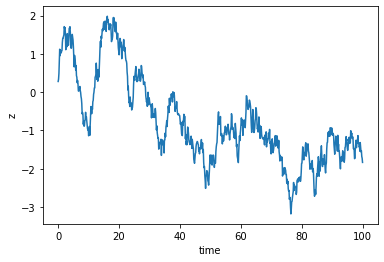

In [3]:
dt = 3 # hours
u = ts.exp_autocorr((100, dt/24), 10, 1, seed=0).compute()
u.plot()

Let's verify the decorrelation timescale is about 10 days

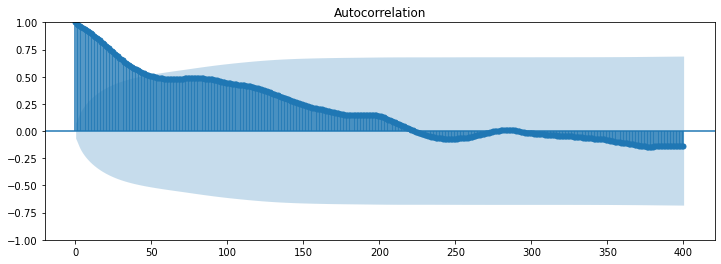

In [4]:
nlags = int(24/dt*50)
fig, ax = plt.subplots(1,1, figsize=(12,4))
_ = sm.graphics.tsa.plot_acf(u, lags=nlags, ax=ax)

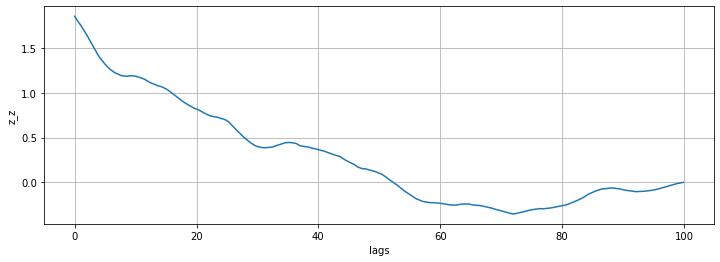

In [5]:
C = sigp.correlate(u, u).persist()
C.plot(figsize=(12,4))
plt.grid()

In [6]:
alpha = 0.1
c_ratio = sigp.likelihood_confidence_ratio(alpha=alpha)
log_c_ratio = np.log(c_ratio)
print(f"Confidence ratio for likelihood = {c_ratio:.2f}, log = {log_c_ratio:.1f}")

Confidence ratio for likelihood = 0.26, log = -1.4


Explore now sensitivity to timescale T

In [7]:
c = lambda dt, T: np.exp(-abs(dt)/T)
T = np.arange(2, 30, .5)

In [8]:
ds_exp = sigp.likelihood_xr(u, c, dict(T=T)) #, jitter=-10

# find maximum
T_max = ds_exp["T"].isel(T=ds_exp.L.argmax())
print(f"Maximum value found at {float(T_max)} days")

# compute second derivative
I = - ds_exp.L.differentiate("T").differentiate("T")

Maximum value found at 13.0 days


Text(0.5, 1.0, 'Likelihood function as a function of decorrelation timescale')

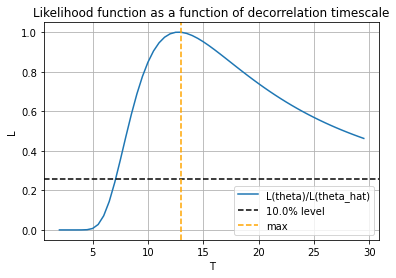

In [9]:
fig, ax = plt.subplots(1,1)
np.exp(ds_exp.L-ds_exp.L.max()).plot(ax=ax, label="L(theta)/L(theta_hat)")
ax.grid()
ax.axhline(c_ratio, ls="--", color="k", label=f"{alpha*100}% level")
ax.axvline(T_max, ls="--", color="orange", label=f"max")
ax.legend()
ax.set_title("Likelihood function as a function of decorrelation timescale")

Inspect the second derivative

 I(T_max) = 0.02, 1/np.sqrt(I)=6.35


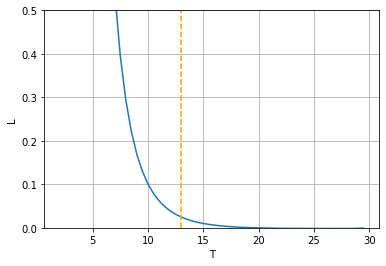

In [10]:
fig, ax = plt.subplots(1,1)
I.plot()
ax.set_ylim(0, .5)
ax.axvline(T_max, color="orange", ls="--")
ax.grid()

I_max = float(I.sel(T=T_max))
print(f" I(T_max) = {I_max:.2f}, 1/np.sqrt(I)={1/np.sqrt(I_max):.2f}")

As a side not, it may be hard to see there is maximum from the log likelihood function:

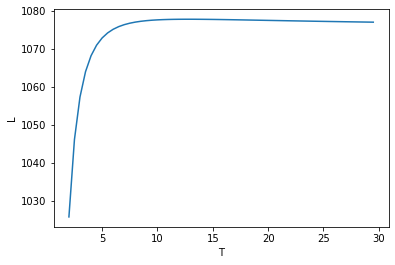

In [11]:
ds_exp.L.plot()

Compare now with a gaussian (erroneous) assumption (instead of an exponential)

In [12]:
c_gaussian = lambda dt, T: np.exp(-abs(dt/T)**2)

In [13]:
ds_gaussian = sigp.likelihood_xr(u, c_gaussian, dict(T=T), jitter=-10) 

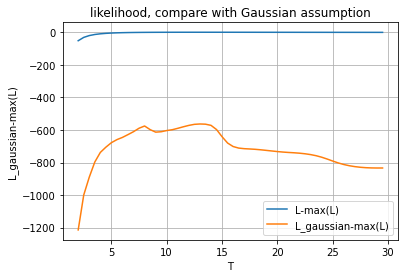

In [14]:
fig, ax = plt.subplots(1,1)
#np.exp(ds.L-ds.L.max()).plot(ax=ax, label="L-max(L)")
#np.exp(ds.L_gaussian-ds.L.max()).rename("L_gaussian").plot(ax=ax, label="L_gaussian-max(L)")
(ds_exp.L-ds_exp.L.max()).plot(ax=ax, label="L-max(L)")
(ds_gaussian.L-ds_exp.L.max()).rename("L_gaussian-max(L)").plot(ax=ax, label="L_gaussian-max(L)")
ax.grid()
ax.set_title("likelihood, compare with Gaussian assumption")
ax.legend()

---

## Optimization to find the maximum

Improvements:

- does not converge (probably need to tweak tolerance manually)
- hessian look wrong from scipy, have to compute manually

In [15]:
def minimize_L(u, t, c, params, deltas=None, options={}, **kwargs):
    """ Minimize log likelihood

    Parameters
    ----------
    u: np.array
        data time series
    t: np.array
        time series
    c: method
        returns the autocorrelation (1 at lag 0) as a function of lag and *args parameters
    params: dict
        dict of initial values for the parameters required to evaluate the autocorrelation with c
        order must match that of c's signature
    deltas: dict
        parameter steps used to compute the log likelihood hessian
    options: dict, optional
        options for the minimization algorithm ("options" kwarg of scipy.optimize.minimize)
    **kwargs:
        kwargs passed to minimize
    """

    labels = list(params)
    # convert to np.array
    x0 = np.array([params[p] for p in labels])

    _options = dict(maxiter=100, disp=True, return_all=True)
    _options.update(**options)

    # maxiter: 6 seems to insure convergence is the present case
    res = minimize(lambda x: -sigp.likelihood_only(u, t, c, *x),
                   x0,
                   #method='Nelder-Mead',
                   options=_options,
                   **kwargs,
                  )
    
    # put the result in a xarray dataset
    niter = len(res["allvecs"])
    ds = xr.Dataset(coords=dict(iteration=("iteration", np.arange(niter)),
                                parameter=("parameter", labels),
                                #parameters_bis=("parameters_bis", labels),
                               ),
                   )
    ds["x"] = ("parameter", res["x"])
    ds["x_iter"] = (("iteration", "parameter"), np.array(res["allvecs"]))
    _exclude = ["allvecs", "hess_inv", "jac", "x", "fun"]
    ds = ds.assign_attrs(L_max = -res["fun"],
                         **{k: v for k,v in res.items() if k not in _exclude},
                        )
    #ds.attrs["hess_inv"] = res["hess_inv"]
    #ds["jac"] = ("parameter", res["jac"])

    # compute hessian diag manually
    params = {p: float(ds["x"].sel(parameter=p))  for p in labels}
    if deltas is None:
        deltas = {p: 1. for p in labels} # need to be passed as argument
    I = sigp.compute_hessian_diag(u, t, c, params, deltas)
    ds["I"] = ("parameter", [I[p] for p in labels])

    ds["x_err"] = 1/np.sqrt(ds["I"])
    
    return ds
    
# default is BFGS, see:
#    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
#    https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs

# could we set a lower bound on increments?

In [16]:
x0 = 5. # should use the max found via profiling
ds_min = minimize_L(u, u.time, c, dict(T=x0), options=dict(maxiter=10))
#ds.attrs["L_max"]

         Current function value: -1077.794505
         Iterations: 10
         Function evaluations: 40
         Gradient evaluations: 20


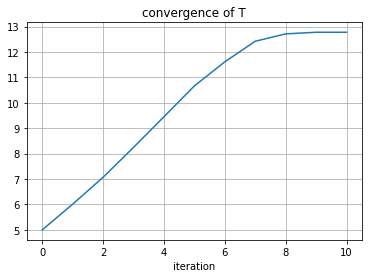

In [17]:
fig, ax = plt.subplots(1,1)
ds_min["x_iter"].plot(ax=ax)
ax.set_title("convergence of T")
ax.set_ylabel("")
ax.grid()

Recompute log-Likelihood to have mean and variance as well as associated asymptotic errors

In [18]:
T = float(ds_min.x)
d = sigp.likelihood(u, u.time, c, T)

In [19]:
print(f"Solution is T = {T:.2f}d with asymptotic error {float(ds_min.x_err):.2e}d")
print("mean = {:.2f} with asymptotic error {:.2e}".format(d["mu"],d["mu_err"]))
print("variance = {:.2f} with asymptotic error {:.2e}".format(d["sigma0"], d["sigma0_err"]))

Solution is T = 12.78d with asymptotic error 8.54e+00d
mean = -0.75 with asymptotic error 1.96e+00
variance = 1.28 with asymptotic error 4.51e-02


Errors on T and sigma0 look way too small, issue with interpretation of the hessian? \
Could try to manually profile the full log likelihood to verify these values

## Questions, to do list 


General questions:

- should we consider EM?

Technical questions:

- dealing with poor covariance conditionning: pseudo-inverse SVD, rcond ? or other approach?
- `sqrt(diag(hess_inv)) =? 1/sqrt(diag(hess))`


To do:

- [X] refine result with scipy optimize
- [X] add asymptotic error bars:  needs to do mean and variance !!
- [ ] fix issue with asymptotic error which looks to small
- [ ] explore sensitivity to parameters (timeseries length, decorrelation timescale, ...)
- [ ] test a different of model of autocorrelation and perform an AIC


---
## multivariate case


---
## combining time windows

In the absence of correlation between windows the overall likelihood will be the sum of the window likelihoods.

This assumption simplifies the estimation of the likehood function.


## old, to be updated: multivariate case

This notebook adapts Fleming et al. 2014 to the estimation of drifter's velocity autocorrelations.
Unlike Fleming et al. 2014, we'll not be concerned with position statistics but velocity statistics.

The velocity is described by its first two cumulants which are:
- it's mean $\boldsymbol{\mu} = \langle \mathbf{u} \rangle$
where $\mathbf{u}=(u, v)$
- its autocorrelation: $\boldsymbol{\sigma}
=\langle (\mathbf{u} - \overline{\mathbf{u}}) ) (\mathbf{u} - \overline{\mathbf{u}}) )^T \rangle$

Note that $u$ and $v$ may represent here two directions of motions or the real and imaginary parts of a complex enveloppe.

We'll assume that the velocity is Gaussian.
**This Gaussian assumption may/should be verified**.

$
\begin{align}
P[\mathbf{u}] = 
\frac{\exp \Big ( -\frac{1}{2}  \iint  dt dt' [ \mathbf{u}(t) - \boldsymbol{\mu}(t) ]^T \boldsymbol{\sigma}^{-1}(t,t') [ \mathbf{u}(t') - \boldsymbol{\mu}(t') ] \Big )  }
{\sqrt{|2\pi \mathbf{\boldsymbol{\sigma}}|}}
\end{align}
$

The discrete version of the time series data is:

$
\begin{align}
P[\mathbf{U}] = 
\frac{\exp \Big ( -\frac{1}{2} [ \mathbf{U} - \mathbf{M} ]^T \boldsymbol{\Sigma}^{-1} [ \mathbf{U} - \mathbf{M} ] \Big )  }
{\sqrt{|2\pi \mathbf{\boldsymbol{\Sigma}}|}}
\end{align}
$

where $\mathbf{U}$ is the velocity time series, $\mathbf{M}$ is the sampled mean, and $\boldsymbol{\Sigma}$ is sampled autocorrelation:

$
\begin{align}
\mathbf{U}_i &=\mathbf{u}(t_i) \\
\mathbf{M}_i &=\boldsymbol{\mu}(t_i) \\
\boldsymbol{\Sigma}_{i,j} &= \boldsymbol{\sigma}(t_i,t_j).
\end{align}
$

where mean and autocorrelation may not be stationary (in general, they will be below).
The log-likelhood function of the probability distribution function is:

$
\begin{align}
l &= -\frac{1}{2} \log | \boldsymbol{\Sigma} | 
- \frac{1}{2} [ \mathbf{U} - \mathbf{M} ]^T \boldsymbol{\Sigma}^{-1} [ \mathbf{U} - \mathbf{M} ]
\end{align}
$

Assuming the autocovariance can be represented by

$
\begin{align}
\boldsymbol{\sigma}(t,t') &=  \boldsymbol{\sigma_0} c(t,t'), \\
\boldsymbol{\sigma_0} &=  \begin{bmatrix}
    \sigma_{xx} & \sigma_{xy} \\
    \sigma_{yx} & \sigma_{yy}
  \end{bmatrix}
\end{align}
$

The log-likelihood function may be written as (**to be verified**):

$
\begin{align}
l &= -\frac{1}{2} \log | \mathbf{C} | 
- \frac{n}{2} \log | \boldsymbol{\sigma}_0 |
- n \frac{\sigma_{yy} s_{xx} + \sigma_{xx} s_{yy} -2 \sigma_{xy} s_{xy} }{2| \boldsymbol{\sigma}_0 |}
\end{align}
$

where the sample correlations are given by:

$
\begin{align}
s_{xx} &= \frac{1}{n} (\mathbf{U}-\mathbf{M}_x)^T \mathbf{C}^{-1} (\mathbf{U}-\mathbf{M}_x)^T, \\
s_{yy} &= \frac{1}{n} (\mathbf{V}-\mathbf{M}_y)^T \mathbf{C}^{-1} (\mathbf{V}-\mathbf{M}_y)^T, \\
s_{xx} &= \frac{1}{n} (\mathbf{U}-\mathbf{M}_x)^T \mathbf{C}^{-1} (\mathbf{V}-\mathbf{M}_y)^T
\end{align}
$

Block matrix inversion and determinant formulas are necessary obtain above formulas, see [wikipedia](https://en.wikipedia.org/wiki/Block_matrix).

Both mean and variances may be solved for analytically as a function of other parameters (see Fleming supplementary material) (**to be verified**):

$
\begin{align}
\mu_x &= \frac{1}{W} \sum_i w_i U_i, \\
\mu_y &= \frac{1}{W} \sum_i w_i V_i, \\
w_i &= \sum_j C^{-1}_{ij}, \\
W &= \sum_i w_i, \\
\hat{\sigma}_{xx} &= s_{xx}, \\
\hat{\sigma}_{yy} &= s_{yy}, \\
\hat{\sigma}_{xy} &= s_{xy},
\end{align}
$

The likehood function reduces then to:

$
\begin{align}
l &= -\frac{1}{2} \log | \mathbf{C} | 
- \frac{n}{2} \log | \boldsymbol{\hat{\sigma}}_0 |
\end{align}
$


